- 앙상블 학습(Ensemble Learning) : 일련의 예측기로부터 예측 수집 → 가장 좋은 모델 하나보다 더 좋은 예측 획득 가능
    - 훈련 세트로부터 랜덤으로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기 훈련
    - 랜덤 포레스트 : 결정 트리의 앙상블

# 1. 투표 기반 분류기

- 직접 투표 분류기(Hard Voting) : 다수결 투표로 정해지는 분류기
    - 약한 학습기 → 앙상블 → 강한 학습기
    - 큰 수의 법칙 적용 가능
- 간접 투표(Soft Voting) : 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 에측을 평균 내어 확률이 가장 높은 클래스 예측 가능

# 2. 배깅과 페이스팅

- 배깅(Bagging) : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅(Pasting) : 중복을 허용하지 않고 샘플링하는 방식
- 훈련 종료 → 예측기의 예측 모음 → 새로운 샘플에 대한 예측
- 분류 → 통계적 최빈값, 회귀 → 평균
- OOB(Out-Of-Bag) : 선택되지 않은 나머지 샘플, 평가에 사용 가능

# 3. 랜덤 패치와 랜덤 서브스페이스

- 랜덤 패치(Random Patches) : 훈련 특성과 샘플 모두 샘플링
- 랜덤 서브스페이스(Random Subspaces) : 훈련 샘플을 모두 사용하고 특성을 샘플링하는 것

# 4. 랜덤 포레스트(Radom Forest)

- 배깅 방법을 적용한 결정 트리 앙상블
- 트리 노드 분할 시 랜덤으로 선택학 특성 후보 중 최적의 특성을 찾는 방법으로 무작위성 주입
- 엑스트라 트리(Extra-Tree) : 극단적으로 랜덤한 트리의 랜덤 포레스트, 익스트림 랜덤 트리
- 특성 상대적 중요도 측정 쉬움

# 5. 부스팅(Boosting)

- 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 기법
- AdatBoost, 그레이디언트 부스팅

## 1. AdaBoost

- 이전 모델이 과소적합했던 훈련 샘플의 가중치 높임 → 학습하기 어려운 샘플에 점점 더 맞춰짐
- 샘플의 가중치를 업데이트하면서 순차적으로 학습
- 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치 적용

## 2. 그레이디언트 부스팅(Gradient Boosting)

- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
- 이전 예측기가 만든 잔여 오차에 새로운 예측기 학습
- 확률적 그레이디언트 부스팅 : 각 트리가 훈련 시 사용할 훈련 샘플 비율 지정

## 3. 히스토그램 기반 그레이디언트 부스팅

- 입력 특성을 구간으로 나누어 정수로 대체하는 방식
- 학습 알고리즘이 평가해야 하는 가능한 임계값의 수 줄이기 가능

# 6. 스태킹(Stacking)

- 앙상블에 속한 모든 예측기의 예측을 취합하는 모델 훈련
- 여러 가지 블랜더를 훈련하여 전체 블렌더 계층을 얻은 다음 그 위에 다른 블렌더를 추가하여 최종 예측

In [1]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [2]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [3]:
voting_clf.predict(X_test[:1])

array([1])

In [4]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [5]:
voting_clf.score(X_test, y_test)

0.912

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [8]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [9]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [10]:
bag_clf.oob_decision_function_[:3]

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [11]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [13]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators=500, n_jobs=-1,
                            random_state=42)

In [14]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50506 (\N{HANGUL SYLLABLE ANH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/pyt

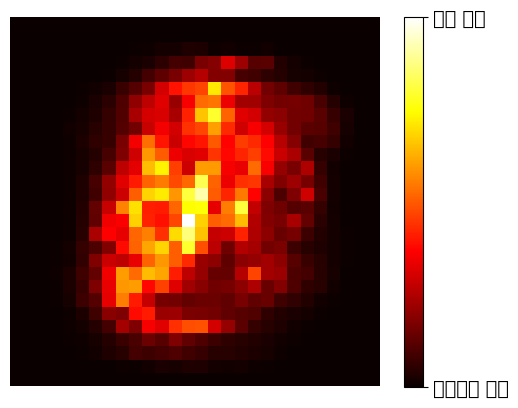

In [15]:
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['중요하지 않음', '매우 중요'], fontsize=14)
plt.axis("off")
plt.show()

In [16]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=30, learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

In [18]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [19]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [20]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [21]:
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51092 (\N{HANGUL SYLLABLE JAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/pytho

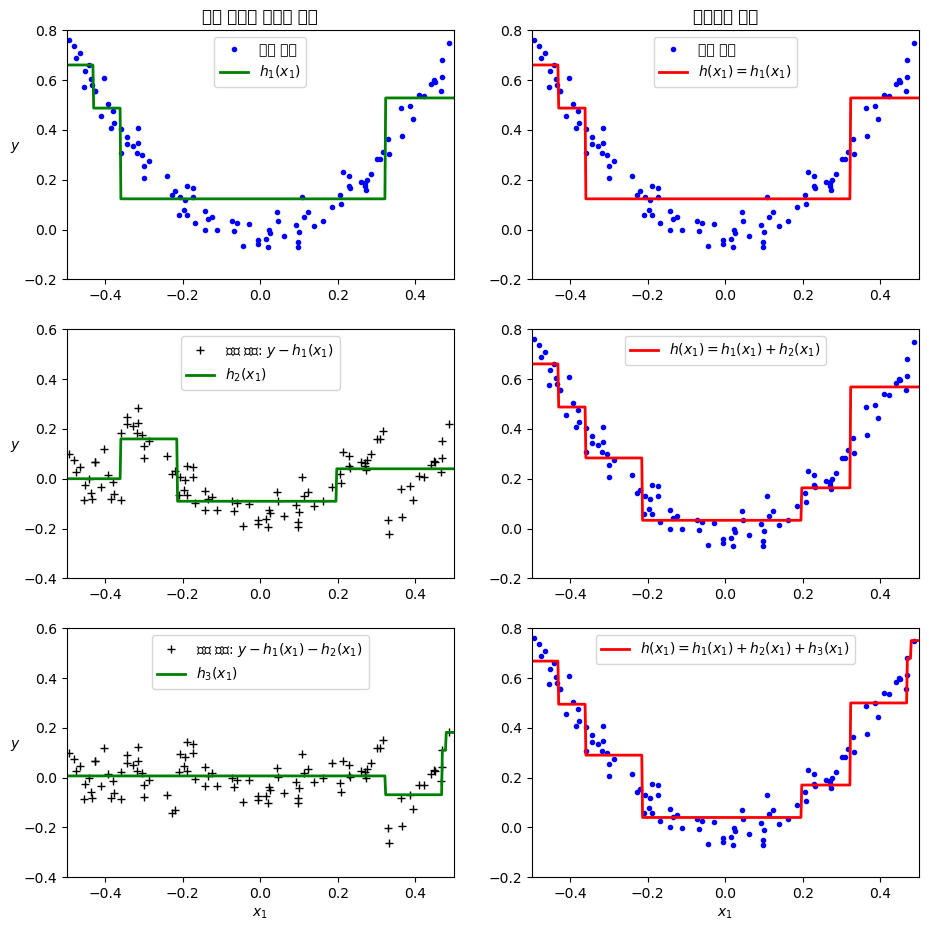

In [22]:
def plot_predictions(regressors, X, y, axes, style, label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)


plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-", label="$h_1(x_1)$", data_label="훈련 세트")
plt.ylabel("$y$  ", rotation=0)
plt.title("잔여 오차와 트리의 예측")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-", label="$h(x_1) = h_1(x_1)$",
                 data_label="훈련 세트")
plt.title("앙상블의 예측")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-", label="$h_2(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-", label="$h_3(x_1)$", data_style="k+",
                 data_label="잔여 오차: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")
plt.show()

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [24]:
gbrt_best = GradientBoostingRegressor(max_depth=2, learning_rate=0.05, n_estimators=500, n_iter_no_change=10,
                                      random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [25]:
gbrt_best.n_estimators_

92

In [26]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request


def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

In [27]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]), remainder="passthrough"),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

In [28]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43), cv=5
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [29]:
stacking_clf.score(X_test, y_test)

0.928